In [1]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import norm
keras = tf.keras
import utils 
from importlib import reload 
print(tf.__version__)

2.3.0


In [2]:
N = 100 # time disrectization    
m = 1 # dimension of price
n = 30
S0 = 1.0 # initial value of the asset
T = 365/365 # maturity
strike = 1.0

option_type = 'eurocall'
# option_type = 'eurodigitalcall'

if option_type == 'eurocall':
    payoff_function = lambda x : 0.5*(np.abs(x-strike)+x-strike) # European call option payoff
if option_type == 'eurodigitalcall':
    payoff_function = lambda x : (x-strike) > 0 # European digital call option payoff

### Generate paths

#### Black-Scholes
$$
dS_{t}=\sigma S_{t}\,dW_{t}
$$

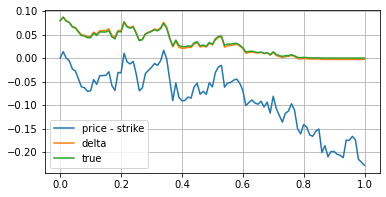

In [3]:
sigma = 0.2
Ktrain = 10**5
price_path, time_grid = utils.simulate_GBM(m,Ktrain,N,T,sigma,S0, 'equi')
payoff = payoff_function(price_path[:,-1]) 
delta_output, delta_path, option_path = utils.delta_hedge(price_path,payoff,T,strike,sigma,option_type,time_grid)

for i in range(1):
    plt.figure(figsize = [6,3])
    plt.plot(time_grid, price_path[i,:,0].T - S0, label = 'price - strike')
    plt.plot(time_grid, delta_path[i,:,0].T, label = 'delta')
    plt.plot(time_grid, option_path[i,:,0].T, label = 'true')
    plt.legend()
    plt.grid()
    plt.show()

#### Heston 
$$
dS_{t}={\sqrt  {V_{t}}}S_{t}\,dW_{t}^{S}
$$
$$
dV_{t}=\kappa (\theta -V_{t})\,dt+\sigma {\sqrt  {V_{t}}}\,dW_{t}^{{\nu }}
$$

Feller condition

$$
2\kappa \theta >\sigma ^{2}
$$


In [4]:
# import QuantLib as ql
# # parameters from "Deep Hedging"
# kappa = 1  # mean reversion strength
# sigma = 2  # vol of vol
# rho = -0.7  # corr between asset price and var
# theta = 0.04

# volatility = np.sqrt(theta)
# v0 = theta # historical vols for the stock  
# Ktrain = 10**5
# print(2*kappa*theta - sigma**2)

# price_path, vol_path = utils.simulate_Heston(m,Ktrain,N,T,rho,kappa,theta,sigma,S0,v0)
# payoff = payoff_function(price_path[:,-1]) 
# price_path_all = np.concatenate([price_path, vol_path],axis = -1)

# plt.figure(figsize = [6,3])
# plt.plot(price_path[:3,:,0].T - S0, label = 'price - strike')
# plt.legend()
# plt.grid()
# plt.show()

# plt.figure(figsize = [6,3])
# plt.plot(vol_path[:3,:,0].T, label = 'volatility')
# plt.legend()
# plt.grid()
# plt.show()

### Expected Shortfall

$$
\rho(X)={\frac {1}{1 - \alpha }}\int _{0}^{1 - \alpha }\operatorname {VaR} _{\gamma }(X)\,d\gamma 
$$

In [5]:
def ES(alpha,X):
    VaR = - np.quantile(X,1-alpha)
    ES = - np.mean(X*(X < VaR))  / (1-alpha)
    return VaR, ES

def ESnormal(alpha):
    from scipy.stats import norm
    VaR = -norm.ppf(1-alpha)
    ES = norm.pdf(norm.ppf(1-alpha))/(1-alpha)
    return VaR, ES

def tfES(alpha,X):
    import tensorflow_probability as tfp
    VaR = -tfp.stats.percentile(X, q=(1-alpha)*100,interpolation='linear')
    ES = - tf.reduce_mean(X*tf.cast((X < VaR),tf.float32))  / (1-alpha)
    return VaR, ES

In [6]:
X = np.random.normal(size = [10000])
alpha = 0.99
print(ES(alpha,X))
print(ESnormal(alpha))
print(tfES(alpha,X))

(2.35472518583079, 2.5800333153293566)
(2.3263478740408408, 2.665214220345806)
(<tf.Tensor: shape=(), dtype=float64, numpy=2.354725185830791>, <tf.Tensor: shape=(), dtype=float32, numpy=2.5800328>)


### Build the deep hedging dynamic 

Value process
$$
V_{t} = \int_{0}^{t}H_{t}dS_{t} + \alpha \int_{0}^{t}(S_{t}dH_{t})^{2} \cdot \text{(trans_cost =True)}
$$
Objective function
\begin{equation}
\begin{split}
\min_{H_{t}}\quad & E\bigg[(f(S_{T})-V_{T})^2\bigg] \\
+ &\beta E\bigg[\int_{0}^{T}(C_{t} - V_{t})^{2}dt\bigg] \cdot \text{(control_path =True)}
\end{split}
\end{equation}

where $(C_{t})_{t\geq 0}$ is the call option price and $f$ is the payoff function.

In [7]:
def build_dynamic(m, N, control_path, trans_cost):
    
    d = 3 # number of layers in strategy
    n = 32  # nodes in the first but last layers
    Networks = utils.build_network(m, n , d, N)
    Network0 = keras.layers.Dense(m, use_bias=False)
    
    # Non-recurrent structure

    price = keras.Input(shape=(N+1,m))   # S_{t}; t=0,..,N+1; (batch, N+1, m)
    benchmark_hedge = keras.Input(shape=(N+1,m))   # V_{t}; t=0,..,N+1; (batch, N+1, m)
    payoff = keras.Input(shape=(m))
    if control_path:
        inputs = [price, payoff, benchmark_hedge]
    else:
        inputs = [price, payoff]
    price_difference = price[:,1:,:] - price[:,:-1,:]  # dS_{t}; t=0,..,N; (batch, N, m)
    premium = Network0(tf.ones_like(price[:,0,:])) # premium; (batch, m)
#     premium = 0
    HEDGE = [None]*(N+1)
    HEDGE[0] = tf.zeros_like(price[:,0,:])
    STRATEGY = [None]*N
    for j in range(N):
        STRATEGY[j] = Networks[j](tf.math.log(price[:,j,:])) # H_{t} = nn(S_{t}); (batch, m)
        cost = 0
        if trans_cost and j > 0: 
            cost = 0.005*((STRATEGY[j]- STRATEGY[j-1])*price[:,j,:])**2
        HEDGE[j+1] = HEDGE[j] + STRATEGY[j] * price_difference[:,j,:] - cost # dX_{t} = H_{t}dS_{t}; (batch, m)
    outputs = premium + HEDGE[-1] # premium + \int_{0}^{T}H_{t}dS_{t}; (batch, m)
    model_hedge = keras.Model(inputs = inputs, outputs=outputs)
    
#     mse = tf.keras.losses.MeanSquaredError()
#     model_hedge.add_loss(mse(outputs, payoff))   

    loss = premium + 1/(1 - alpha)*tf.nn.relu(payoff - outputs)
    loss = tf.reduce_mean(loss)
    model_hedge.add_loss(loss)  

    if control_path:
        for j in range(N):
            mse = tf.keras.losses.MeanSquaredError()
            model_hedge.add_loss(10*mse(HEDGE[j]+premium, benchmark_hedge[:,j]))   
    
    return model_hedge, Network0, Networks


In [8]:
model_hedge, Network0, Networks = build_dynamic(m, N, False, False)

### Train the model

In [9]:
control_path = False
if not control_path:
    option_path = price_path
split = int(Ktrain/2)
xtrain = [price_path[:split], payoff[:split], option_path[:split]]  # input be price_path
ytrain = payoff[:split]*0  # output be payoff
xtest = [price_path[split:], payoff[:split], option_path[split:]]  # input be price_path
ytest = payoff[split:]*0  # output be payoff

In [10]:
def zeroloss(y_true, y_predict):
    return tf.reduce_sum(y_predict*0)

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005) # specify the optmizer 
# model_hedge.compile(optimizer = optimizer,loss='mse') # specify the mean square loss 
model_hedge.compile(optimizer = optimizer,loss=zeroloss) # specify the expected shortfall
model_hedge.fit(x=xtrain,y=ytrain, epochs=20,verbose=True,batch_size=1000) # train the model 

Epoch 1/20
50/50 [==============================] - 1s 27ms/step - loss: 112.6115
Epoch 2/20
50/50 [==============================] - 1s 26ms/step - loss: 86.5756
Epoch 3/20
50/50 [==============================] - 1s 25ms/step - loss: 62.1573
Epoch 4/20
50/50 [==============================] - 1s 28ms/step - loss: 38.5473
Epoch 5/20
50/50 [==============================] - 1s 25ms/step - loss: 15.2741
Epoch 6/20
50/50 [==============================] - 1s 25ms/step - loss: 0.7147
Epoch 7/20
50/50 [==============================] - 1s 26ms/step - loss: 0.1315
Epoch 8/20
50/50 [==============================] - 1s 25ms/step - loss: 0.1283
Epoch 9/20
50/50 [==============================] - 1s 26ms/step - loss: 0.1254
Epoch 10/20
50/50 [==============================] - 1s 26ms/step - loss: 0.1225
Epoch 11/20
50/50 [==============================] - 1s 26ms/step - loss: 0.1197
Epoch 12/20
50/50 [==============================] - 1s 26ms/step - loss: 0.1173
Epoch 13/20
50/50 [============

In [12]:
pi = model_hedge.evaluate(x=xtrain,y=ytrain)

1563/1563 [==============================] - 5s 3ms/step - loss: 0.1074


### Compared with delta hedging 

In [13]:
hedge_output_train = model_hedge.predict(xtrain) # compute the output (deep replicate payoff) with trained model 
hedge_output_test = model_hedge.predict(xtest) # compute the output (deep replicate payoff) with trained model

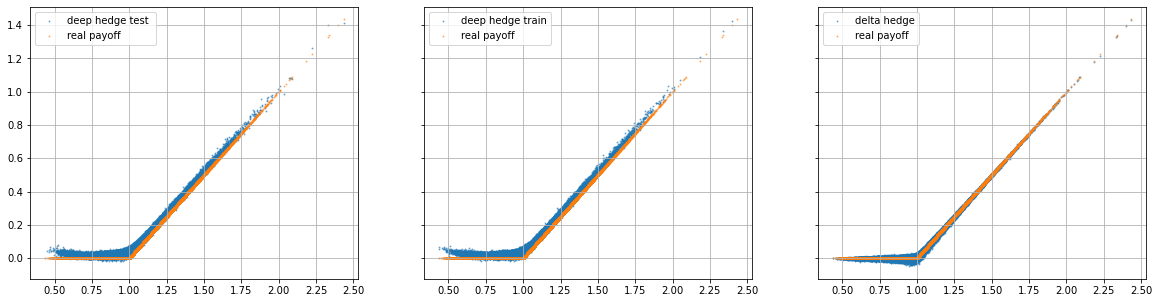

In [14]:
f,p = plt.subplots(1,3, figsize = [20,5], sharey = True)
p[0].scatter(price_path[split:,-1,0], hedge_output_test[:,0], s = 1, alpha = 0.5, label = 'deep hedge test ')   # deep replicate payoff 
p[1].scatter(price_path[:split,-1,0], hedge_output_train[:,0], s = 1, alpha = 0.5, label = 'deep hedge train')   # deep replicate payoff 
p[2].scatter(price_path[:,-1,0], delta_output[:,0], s = 1, alpha = 0.5, label = 'delta hedge')   # delta replicate payoff 
for i in range(3):
    p[i].scatter(price_path[:,-1,0], payoff[:,0], s = 1, alpha = 0.5, label = 'real payoff')        # real payoff
    p[i].legend()
    p[i].grid()

In [15]:
# f,p = plt.subplots(1,5,figsize = [20,5])
# for i in range(5):
#     n = 20*i + 10
#     pr = np.linspace(0.5,2,100)[:,None]  # tf.tensor of different price 

#     he = Networks[n](pr) # the stategy network 
#     p[i].plot(pr[:,0],he[:,0], label = 'deep hedge') # plot the relation between price and deep strategy

#     _,delta = utils.BlackScholes(T - time_grid[n], pr, strike, sigma, option_type)
#     p[i].plot(pr, delta, label = 'delta hedge') # plot the relation between price and delta strategy
#     p[i].title.set_text(f"At time: {time_grid[n]:{1}.{4}}")
#     p[i].legend()
#     p[i].grid()
# plt.show()

In [16]:
# Hedge = [None] * N
# transaction_cost = 0
# for j in range(N):
#     Hedge[j] = Networks[j](price_path[:,j,:])
#     if j > 0: 
#         transaction_cost += 0.005*(Hedge[j]*price_path[:,j-1,:] - Hedge[j-1]*price_path[:,j-1,:])**2
# print(transaction_cost[:,0].numpy().mean())
# plt.hist(transaction_cost[:,0].numpy())

In [17]:
print(f"deep premium: {Network0(tf.ones([1,1])).numpy()[0,0]:{1}.{4}}")         # premium of deep hedge (truncted printing)
helper,_ = utils.BlackScholes(T, S0, strike, sigma, option_type)
print(f"real premium: {helper:{1}.{4}}")           # real premium

deep premium: 0.1048
real premium: 0.07966
